In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer #for tfidf

from sklearn.feature_extraction.text import CountVectorizer #for BOW
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#we take 15k review for analysis

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 300000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (300000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
#Sorting data according to ProductId in ascending order

sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries

final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(228569, 10)

In [5]:
#Checking to see how much % of data still remains

(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

76.18966666666667

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(228567, 10)


1    192377
0     36190
Name: Score, dtype: int64

In [8]:
# since we have to clean text column for any kind grammatical error or any  unwanted things we take it separately and then clean

sent_0 = final['Text']
print(sent_0)

138694    I set aside at least an hour each day to read ...
138692    TITLE: Chicken Soup with Rice<br />AUTHOR: Mau...
138691    This is a book of poetry about the months of t...
138690    This is a great little book to read aloud- it ...
138689    This is a fun way for children to learn their ...
                                ...                        
178134    I have been using this product a bit over six ...
178145    LOVE, LOVE this sweetener!!  I use it in all m...
173675    You have to try this sauce to believe it! It s...
204727    I bought this Hazelnut Paste (Nocciola Spread)...
5259      Purchased this product at a local store in NY ...
Name: Text, Length: 228567, dtype: object


In [9]:
#to remove http://(web link) from reviews

sent_0 = re.sub(r"http\S+", "", str(sent_0))

In [10]:
#Beautiful Soup is used to pull data out html and xml files

from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)

138694    I set aside at least an hour each day to read ...
138692    TITLE: Chicken Soup with RiceAUTHOR: Mau...
138691    This is a book of poetry about the months of t...
138690    This is a great little book to read aloud- it ...
138689    This is a fun way for children to learn their ...
                                ...                        
178134    I have been using this product a bit over six ...
178145    LOVE, LOVE this sweetener!!  I use it in all m...
173675    You have to try this sauce to believe it! It s...
204727    I bought this Hazelnut Paste (Nocciola Spread)...
5259      Purchased this product at a local store in NY ...
Name: Text, Length: 228567, dtype: object


In [11]:
#decotracted is used to expand common english words into clear texts

import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


In [12]:
sent_0 = decontracted(sent_0)
print(sent_0)

138694    I set aside at least an hour each day to read ...
138692    TITLE: Chicken Soup with Rice<br />AUTHOR: Mau...
138691    This is a book of poetry about the months of t...
138690    This is a great little book to read aloud- it ...
138689    This is a fun way for children to learn their ...
                                ...                        
178134    I have been using this product a bit over six ...
178145    LOVE, LOVE this sweetener!!  I use it in all m...
173675    You have to try this sauce to believe it! It s...
204727    I bought this Hazelnut Paste (Nocciola Spread)...
5259      Purchased this product at a local store in NY ...
Name: Text, Length: 228567, dtype: object


In [13]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I set aside at least an hour each day to read ...
    TITLE: Chicken Soup with Rice<br />AUTHOR: Mau...
    This is a book of poetry about the months of t...
    This is a great little book to read aloud- it ...
    This is a fun way for children to learn their ...
                                ...                        
    I have been using this product a bit over six ...
    LOVE, LOVE this sweetener!!  I use it in all m...
    You have to try this sauce to believe it! It s...
    I bought this Hazelnut Paste (Nocciola Spread)...
      Purchased this product at a local store in NY ...
Name: Text, Length:  dtype: object


In [14]:
#if word contains other than letters and numbers replace it with blank space

sent_0 = re.sub('[^A-Za-z0-9]+', ' ', sent_0)
print(sent_0)

I set aside at least an hour each day to read TITLE Chicken Soup with Rice br AUTHOR Mau This is a book of poetry about the months of t This is a great little book to read aloud it This is a fun way for children to learn their I have been using this product a bit over six LOVE LOVE this sweetener I use it in all m You have to try this sauce to believe it It s I bought this Hazelnut Paste Nocciola Spread Purchased this product at a local store in NY Name Text Length dtype object


In [15]:
sent_0[4] #by this example we understand 'sent_0'  contains only first review, and we did cleaning on first review only.

't'

In [16]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [17]:
#  now do the cleaning on all reviews

from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 228567/228567 [01:08<00:00, 3344.80it/s]


In [519]:
#create a new column "CleanedText" and transfer all the text that is just being cleaned

final['CleanedText']=preprocessed_reviews

In [520]:
#To see whether we succussfully added cleanedText column

final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138694,150512,0006641040,A1DJXZA5V5FFVA,A. Conway,0,0,1,1338249600,Must have.,I set aside at least an hour each day to read ...,set aside least hour day read son point consid...
138692,150510,0006641040,AM1MNZMYMS7D8,Dr. Joshua Grossman,0,0,1,1348358400,Professional Mentoring,TITLE: Chicken Soup with Rice<br />AUTHOR: Mau...,title chicken soup riceauthor maurice sendakre...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...


In [521]:
Y=final['Score'].values
X=final['CleanedText'].values

# Splitting Train,Cross-validate,Test data

In [522]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting , 33% data are test data.
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting 33% remaining Test data are CV data


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)



(102603,) (102603,)
(50536,) (50536,)
(75428,) (75428,)


# BOW

In [532]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train)            # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector

X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)       # CV data fits in the dimensions sets by Train data
X_test_bow = vectorizer.transform(X_test)   # Test data fits in the dimensions sets by Train data

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)



After vectorizations
(102603, 60764) (102603,)
(50536, 60764) (50536,)
(75428, 60764) (75428,)


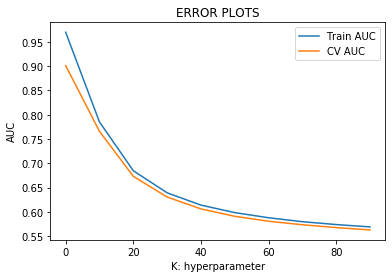

In [533]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


train_auc = []
cv_auc = []
#K=np.arange(1,100,2)
K= np.arange(0.01,100,10)
#K= [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
for i in K:
    neigh = MultinomialNB(alpha= i, fit_prior=True, class_prior=None)  #simple search to find k in k-nn using brute force algorithm
    neigh.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]   #predicting 'y' in train data
    y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]         #predicting 'y' in CV data
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))   #validating predicted values with actual value for given value 'k' and draw AUC
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Till Alpha=40 it tails off massively, then it starts to stabilize, means its start underfitting

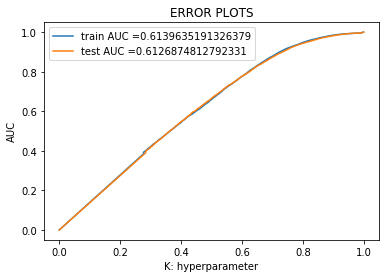

In [534]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = MultinomialNB(alpha= 40, fit_prior=True, class_prior=None)
neigh.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow)[:,1])

y_test_pred =  neigh.predict_proba(X_test_bow)[:,1]

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



In [535]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [536]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.3312983538705347 for threshold 1.0
Train confusion matrix
[[ 7153  8977]
 [29876 56597]]
Test confusion matrix
[[ 6872  5141]
 [26634 36781]]


###### Heat maps

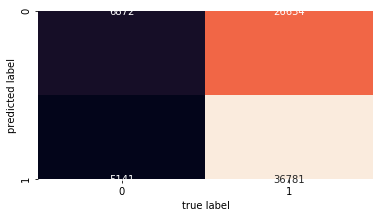

In [537]:
from sklearn.metrics import confusion_matrix
mat1 = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
sns.heatmap(mat1.T,center=None, square=True, annot=True, fmt='d', cbar=False,
            xticklabels='auto', yticklabels='auto')
plt.xlabel('true label')
plt.ylabel('predicted label');

###### Feature Importance

In [538]:
print("Top 10 features that decides negative class")
neg_class_prob_sorted = neigh.feature_log_prob_[0, :].argsort()
print(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:10]))
print("=====")

print("Top 10 features that decides positive class")
pos_class_prob_sorted = neigh.feature_log_prob_[1, :].argsort()
print(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[:10]))

Top 10 features that decides negative class
['zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz' 'sweatshops' 'keenwa' 'keepa'
 'sweatner' 'keepin' 'sweatiness' 'keepingit' 'keepit' 'keepour']
=====
Top 10 features that decides positive class
['cinnamos' 'hedonism' 'mouisture' 'mouldy' 'moulin' 'mounain' 'thuff'
 'mounded' 'riveted' 'hebrew']


## tfidf

In [539]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10) #initalizing
tf_idf_vect.fit(X_train)

A_train_bow = tf_idf_vect.transform(X_train)
A_cv_bow = tf_idf_vect.transform(X_cv)       # CV data fits in the dimensions sets by Train data
A_test_bow = tf_idf_vect.transform(X_test)   # Test data fits in the dimensions sets by Train data

print("After vectorizations")
print(A_train_bow.shape, y_train.shape)
print(A_cv_bow.shape, y_cv.shape)
print(A_test_bow.shape, y_test.shape)
print("="*100)



After vectorizations
(102603, 59922) (102603,)
(50536, 59922) (50536,)
(75428, 59922) (75428,)


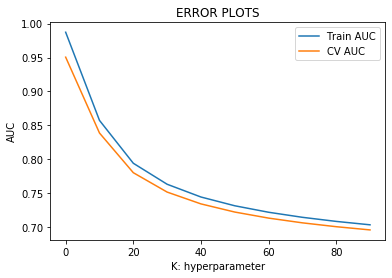

In [540]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


train_auc = []
cv_auc = []
#K=np.arange(1,100,2)
K= np.arange(0.01,100,10)
#K= [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
for i in K:
    neigh = MultinomialNB(alpha= i, fit_prior=True, class_prior=None)  #simple search to find k in k-nn using brute force algorithm
    neigh.fit(A_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    b_train_pred =  neigh.predict_proba(A_train_bow)[:,1]   #predicting 'y' in train data
    b_cv_pred =  neigh.predict_proba(A_cv_bow)[:,1]         #predicting 'y' in CV data
    
    train_auc.append(roc_auc_score(y_train,b_train_pred))   #validating predicted values with actual value for given value 'k' and draw AUC
    cv_auc.append(roc_auc_score(y_cv, b_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

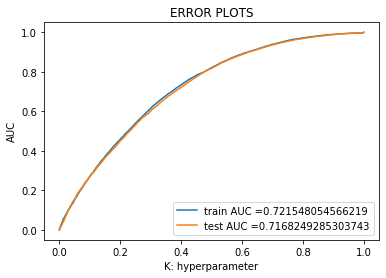

In [541]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = MultinomialNB(alpha= 60, fit_prior=True, class_prior=None)
neigh.fit(A_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, tr2_thresholds = roc_curve(y_train, neigh.predict_proba(A_train_bow)[:,1])
test_fpr, test_tpr, te2_thresholds = roc_curve(y_test, neigh.predict_proba(A_test_bow)[:,1])

b_test_pred =  neigh.predict_proba(A_test_bow)[:,1]

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



In [542]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [543]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr2_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(b_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(b_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.44264419867117477 for threshold 0.978
Train confusion matrix
[[12018  4112]
 [42108 44365]]
Test confusion matrix
[[ 7455  4558]
 [19030 44385]]


###### Heat maps

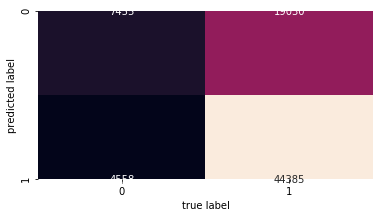

In [544]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, predict_with_best_t(b_test_pred, best_t))
sns.heatmap(mat.T,center=None, square=True, annot=True, fmt='d', cbar=False,
            xticklabels='auto', yticklabels='auto')
plt.xlabel('true label')
plt.ylabel('predicted label');

##### Feature Importance

In [545]:
print("Top 10 features that decides negative class")
neg_class_prob_sorted_1 = neigh.feature_log_prob_[0, :].argsort()
print(np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted_1[:10]))
print("=====")

print("Top 10 features that decides positive class")
pos_class_prob_sorted_1 = neigh.feature_log_prob_[1, :].argsort()
print(np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted_1[:10]))

Top 10 features that decides negative class
['stares' 'trying loose' 'good large' 'tea fantastic' 'box though'
 'first trying' 'liked best' 'water needed' 'packets perfect' 'box take']
=====
Top 10 features that decides positive class
['smelled rancid' 'back refund' 'plain nasty' 'zero star' 'recommend stay'
 'worst taste' 'horrible product' 'inedible not' 'stuff terrible' 'ripoff']


# Conclusion:

In [546]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer","Hyperparameter", "AUC"]

x.add_row(["BOW",  40, 0.61])
x.add_row(["tfidf",  60, 0.76])

print(x)

+------------+----------------+------+
| Vectorizer | Hyperparameter | AUC  |
+------------+----------------+------+
|    BOW     |       40       | 0.61 |
|   tfidf    |       60       | 0.76 |
+------------+----------------+------+
